# Magic the Gathering - Scryfall
Scripting Notebook

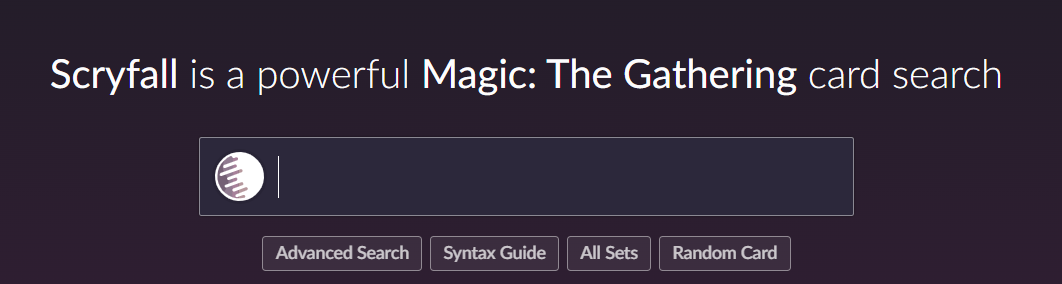

*https://scryfall.com/*


## Introduction:
This notebook outlines various methods of pulling Scryfall API data into a pandas dataframe (among some other methods):
### Pulling JSON Data with the API:
* **`bulk_oracle_scry`**: A single pull of all single cards (most recently printed in the case of reprints) using the `bulk_oracle_scry` method (bulk oracle data is updated in Scryfall daily). This is a good choice if you are looking to do a deep analysis for deckbuilding across multiple colors / formats.
* **`scry`**: A pull of cards which fit a specified query using the `scry` method (query syntax is outlined here: https://scryfall.com/docs/syntax).

### Packaging into a Dateframe

#### Considerations and Caveats - The "Scryframe"
* Multi-face Cards: Each multiface card will be put into a single row for each face, plus one additional row representing the card as a whole. These rows will share the same id. 

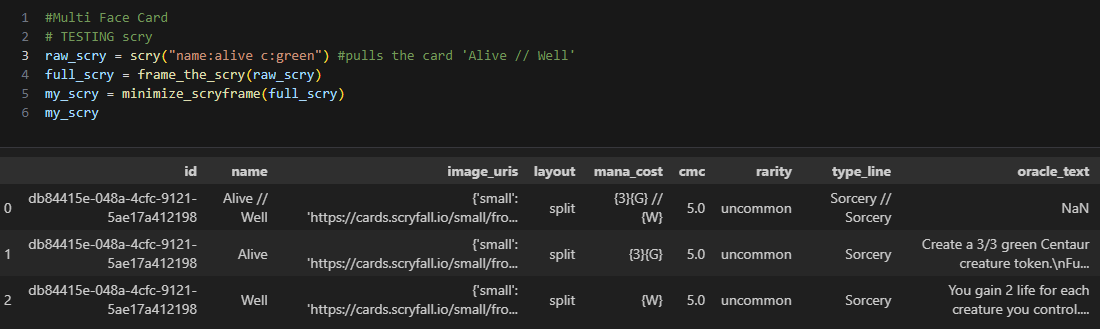

* Standard Price: The minimized scryframe will only return one price. The price selection is prioritized as follows (the first one found is selected as the `standard_price`): `usd` > `usd_foil` > "the average of all prices available" > `0.00` 

#### Extra Method - Pretty Print
* I've included an additional method that is usefull for printing out specific card data (including the card image):

*Example*:

`pretty_print(df=my_scry[['name','image_uris','price']], show_images=True, image_size='normal')`

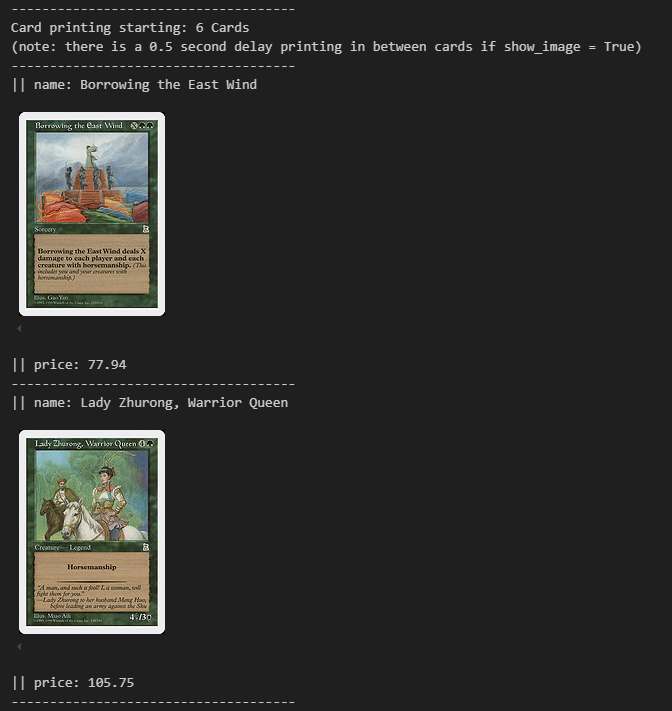


## Requirements

In [14]:
#imports ----------------------------------------------------------------------------------
import requests
from PIL import Image
from io import BytesIO
import pandas as pd
import time
import numpy as np
import ast
import tkinter as tk
from tkinter import messagebox

## API Methods

In [ ]:
"""
Requirements:
import requests
import time
import tkinter as tk
from tkinter import messagebox
"""
# scryfall API methods ---------------------------------------------------------------------------------- 
def bulk_oracle_scry():
    """
    Review Bulk Data availability here:
    https://scryfall.com/docs/api/bulk-data
    Review Bulk Data API here:
    https://scryfall.com/docs/api/bulk-data/all

    # This is the 'Oracle Cards' json data link of the day (containing one Scryfall card object for each Oracle ID on Scryfall) -- there are other bulk data options on scryfall...
    """
    response = requests.get("https://api.scryfall.com/bulk-data") #this is the url to the day's bulk json data links on Scryfall website
    data = response.json()
    time.sleep(0.5)
    response = requests.get(data['data'][0]['download_uri']) #this is the 'Oracle Cards' json data link of the day (containing one Scryfall card object for each unique play card on Scryfall)
    data = response.json()
    time.sleep(0.5)
    return data

# ------------------------------------------------------------------------------------------------------
def scry(q, unique = True):
    """
    Review query (q) syntax here:
    https://scryfall.com/docs/syntax
    example of final data structure needed within method:
    query={"q":"oracle:goad format:commander", "unique": "cards"}
    ...where the passed q = "oracle:goad format:commander" and passed unique = True or False
    # TESTING
    scry("oracle:goad name:Mutation format:commander") #should return a json like data structure with a single card object (Acquired Mutation)  
    """
    url = "https://api.scryfall.com/cards/search"
    #build up scry query
    query = {"q":q}
    if unique:
        query["unique"] = "cards"
        all_cards = []
        has_more = True
        page = 1
    while has_more:
        response = requests.get(url, params=query)
        data = response.json()
        # Add cards from the current page
        all_cards.extend(data.get('data', []))
        # Check if there's another page
        has_more = data.get("has_more", False)
        # Update the URL to the next page if more cards exist
        if has_more:
            print("---- New Page ----")
            query['page'] = page
            if page > 5:
                has_more = False
            else:
                page += 1
    time.sleep(0.5)
    return all_cards

# ------------------------------------------------------------------------------------------------------
def scry_all():
    print("Manually download the full dataset online from https://scryfall.com/docs/api/bulk-data ('All Cards' includes re-prints)... Method for pulling this within script is not available at this time.")

## Dataframe (Scryframe) Methods

In [16]:
# scryframe building methods -------------------------------------------------------------------------------------
"""
Requirements:
import pandas as pd
import numpy as np
"""
def standard_price(prices):
    #prices=return_as_dict(prices)
    primary_price_key = 'usd'
    alternative_key = 'usd_foil'
    standard_price = 0.00 #usd // default
    if (primary_price_key in prices) and (prices[primary_price_key] != None):
        standard_price = prices[primary_price_key]
    elif (alternative_key in prices) and (prices[alternative_key] != None):
        standard_price = prices[alternative_key]
    else:
        temp = 0.00 # used to determine the avg price if any
        count = 0
        for key in prices:
            if prices[key] != None:
                value = prices[key]
                if str(value).replace('.', '', 1).isdigit():
                    value = float(value)
                    temp = temp + value
                    count = count + 1
        if temp > 0.00:
            standard_price = temp/count
    return standard_price

# ------------------------------------------------------------------------------------------------------
def expand_prices(prices):
    data = {}
    for price_type in prices:
        data_key = ('price_'+price_type)
        if prices[price_type] != None:
            data[data_key] = float(prices[price_type])
        else:
            data[data_key] = None
    return data

# ------------------------------------------------------------------------------------------------------
def frame_the_scry(raw_scry):
    #Identify the data getting put into columns, needs to match respective keys in raw scry
    col_names = ['id','name','layout', 'mana_cost', 'cmc', 'type_line', 'oracle_text', 'power', 'toughness', 'colors', 'color_identity', 'keywords', 'rarity', 'artist','artist_ids','legalities', 'games', 'reserved', 'flavor_text', 'set_name', 'set_type', 'prices','image_uris']
    #initialize card data
    card_data = {key:[] for key in col_names}
    #loop through card data and pull items into frame
    for card in raw_scry:
        #print(f"Loading {card['name']}") #testing...
        #load card data
        [card_data[key].append(card[key]) if key in card.keys() else card_data[key].append(np.nan) for key in col_names]
        #check for extra card faces
        if "card_faces" in card.keys():
            for card_face in card['card_faces']:
                #print(f"--- Loading Card Face {card_face['name']}")
                #load card face data
                [card_data[key].append(card_face[key]) for key in col_names if key in card_face.keys()]
                #with the new card face row data, fill in data gaps with previous info
                max_count = max([len(card_data[key]) for key in col_names])
                [card_data[key].append(card_data[key][-1]) for key in col_names if len(card_data[key]) < max_count]
    #set the df with the card data
    df = pd.DataFrame(card_data)
    return df

# ------------------------------------------------------------------------------------------------------
def minimize_scryframe(df, select_columns = ['id','name','image_uris', 'layout', 'mana_cost','cmc', 'rarity','type_line', 'oracle_text', 'power', 'toughness', 'colors', 'color_identity', 'keywords', 'price']): # ---------------------------------------------------------------------------
    #Assumes the df came from the 'frame_the_scry' method
    if 'price' in select_columns:
        #price reporting
        df['price'] = [standard_price(x) for x in df['prices']]
        df['price'] = pd.to_numeric(df['price'])
    #At this time, I am leaving the following commented out...
    # ... making the id column a categorical will increase the memory space needed to maintain the final df.    
    #if 'id' in select_columns:
    #    df['id'] = df['id'].astype("category")
    return df[select_columns]

# ------------------------------------------------------------------------------------------------------

## Additional Methods (Printing and Reporting)

In [17]:
# scryframe printing methods ----------------------------------------------------------------------------
""" Requirements
from PIL import Image
from io import BytesIO
import time
import ast
"""
# ------------------------------------------------------------------------------------------------------
def show_image(image_url):
    try:
        # Download and display the image
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        #img.show() # Opens the image in the default image viewer (good for Pythonista... not so much for computer...)
        display(img)
        time.sleep(0.5)
    except requests.exceptions.RequestException as e:
        print(f"No Image: {e}")

# ------------------------------------------------------------------------------------------------------
def pretty_print(df, show_images = True, image_size = ['small','normal','large'][0]):
    """If show_image is True, then the default size is 'small'... any of the three options can be passed, though... """
    if show_images == False:
        df = df.drop(columns=['image_uris'], errors='ignore')
    print("-------------------------------------")
    print(f"Card printing starting: {len(df)} Cards")
    print("(note: there is a 0.5 second delay printing in between cards if show_image = True)")
    for _, row in df.iterrows():
        print("-------------------------------------")
        #print(df['image_uris'])
        for col in df:
            if col != 'image_uris':
                print(f'|| {col}: {row[col]}')
            elif pd.isna(row[col]):
                print(f'|| {col}: {row[col]} [No Image]')
            else:
                if isinstance(row[col], dict):
                    show_image(row[col][image_size])# image_size can only be small, normal, or large
                else:
                    show_image(ast.literal_eval(row[col])[image_size])
    print("-------------------------------------")
    print(f"Card printing complete: {len(df)} Cards")
    print("-------------------------------------")


## Testing Blocks

In [18]:
# TESTING scry
raw_scry = scry("oracle:horsemanship c:g format:commander") #pulls the most up-to-date data direct from the scryfall website
full_scry = frame_the_scry(raw_scry)
my_scry = minimize_scryframe(full_scry)
my_scry

,id,name,image_uris,layout,mana_cost,cmc,rarity,type_line,oracle_text,power,toughness,colors,color_identity,keywords,price
0,96ba9014-d750-4924-aa6f-8b9f421807f9,Borrowing the East Wind,{'small': 'https://cards.scryfall.io/small/fro...,normal,{X}{G}{G},2.0,rare,Sorcery,Borrowing the East Wind deals X damage to each...,NaN,NaN,[G],[G],[],77.94
1,009661e7-c704-43a1-82e3-7da0b609844e,"Lady Zhurong, Warrior Queen",{'small': 'https://cards.scryfall.io/small/fro...,normal,{4}{G},5.0,rare,Legendary Creature — Human Soldier Warrior,Horsemanship (This creature can't be blocked e...,4,3,[G],[G],[Horsemanship],105.75
2,56fe32f2-8967-4814-b43b-bdccd2019bdf,Riding the Dilu Horse,{'small': 'https://cards.scryfall.io/small/fro...,normal,{2}{G},3.0,uncommon,Sorcery,Target creature gets +2/+2 and gains horsemans...,NaN,NaN,[G],[G],[],0.05
3,023ae64a-7888-4ad2-b879-0649d8e341ac,Taoist Mystic,{'small': 'https://cards.scryfall.io/small/fro...,normal,{2}{G},3.0,rare,Creature — Human Mystic,This creature can't be blocked by creatures wi...,2,2,[G],[G],[],44.49
4,6ba99278-0a8f-4cee-8a50-dfac97996106,Trip Wire,{'small': 'https://cards.scryfall.io/small/fro...,normal,{2}{G},3.0,common,Sorcery,Destroy target creature with horsemanship.,NaN,NaN,[G],[G],[],0.06
5,e3425241-efdc-4261-a2bb-58fbf4a9fe8c,"Zuo Ci, the Mocking Sage",{'small': 'https://cards.scryfall.io/small/fro...,normal,{1}{G}{G},3.0,rare,Legendary Creature — Human Advisor,Hexproof (This creature can't be the target of...,1,2,[G],[G],[Hexproof],44.98


-------------------------------------
Card printing starting: 6 Cards
(note: there is a 0.5 second delay printing in between cards if show_image = True)
-------------------------------------
|| name: Borrowing the East Wind


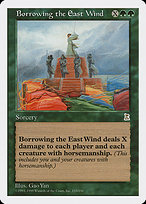

|| price: 77.94
-------------------------------------
|| name: Lady Zhurong, Warrior Queen


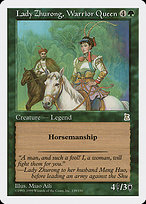

|| price: 105.75
-------------------------------------
|| name: Riding the Dilu Horse


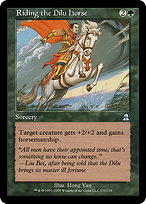

|| price: 0.05
-------------------------------------
|| name: Taoist Mystic


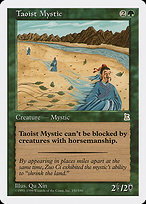

|| price: 44.49
-------------------------------------
|| name: Trip Wire


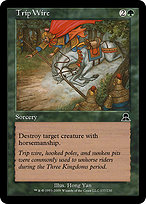

|| price: 0.06
-------------------------------------
|| name: Zuo Ci, the Mocking Sage


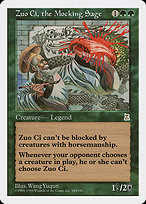

|| price: 44.98
-------------------------------------
Card printing complete: 6 Cards
-------------------------------------


In [19]:
pretty_print(df=my_scry[['name','image_uris','price']], show_images=True, image_size='small')

In [ ]:
#Multi Face Card
# TESTING scry
raw_scry = scry("name:alive c:green") #pulls the card 'Alive // Well'
full_scry = frame_the_scry(raw_scry)
my_scry = minimize_scryframe(full_scry)
my_scry

,id,name,image_uris,layout,mana_cost,cmc,rarity,type_line,oracle_text,power,toughness,colors,color_identity,keywords,price
0,db84415e-048a-4cfc-9121-5ae17a412198,Alive // Well,{'small': 'https://cards.scryfall.io/small/fro...,split,{3}{G} // {W},5.0,uncommon,Sorcery // Sorcery,NaN,NaN,NaN,"[G, W]","[G, W]",[Fuse],0.04
1,db84415e-048a-4cfc-9121-5ae17a412198,Alive,{'small': 'https://cards.scryfall.io/small/fro...,split,{3}{G},5.0,uncommon,Sorcery,Create a 3/3 green Centaur creature token.\nFu...,NaN,NaN,"[G, W]","[G, W]",[Fuse],0.04
2,db84415e-048a-4cfc-9121-5ae17a412198,Well,{'small': 'https://cards.scryfall.io/small/fro...,split,{W},5.0,uncommon,Sorcery,You gain 2 life for each creature you control....,NaN,NaN,"[G, W]","[G, W]",[Fuse],0.04
